# Lab 2: Clustering

Welcome to the advanced Machine Learning Course.

The objective of this lab session is to code a few regression algorithms and to apply them to synthetic and real datasets.

Please put **"ML - MDS - TD2"** in the mail subject or I might lose your work (which means 0) and send it to pierre.houdouin@centralesupelec.fr

Please label your notebook **"L2_familyname1_familyname2.ipynb"** or I might lose your work (which means 0).

We begin with the standard imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster # all clustering techniques except hdbscan
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

We will have two toy datasets to try the different methods:

There are a lot of clustering algorithms to choose from the `sklearn` library. So what clustering algorithms should you be using? It depends.

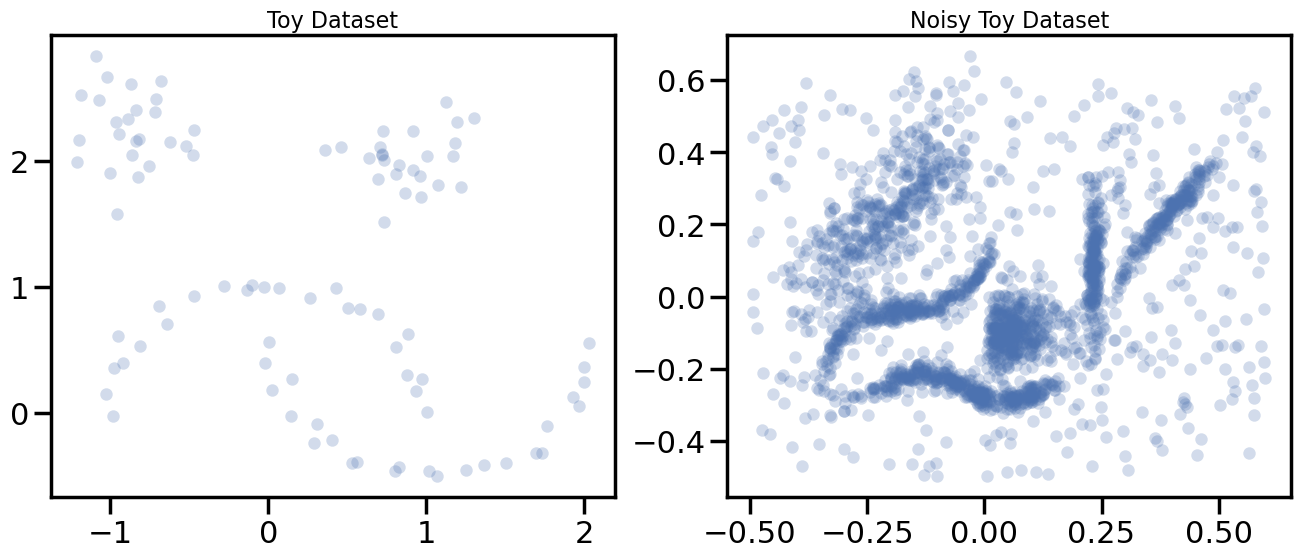

In [2]:
import sklearn.datasets as data
moons, _ = data.make_moons(n_samples=50, noise=0.05)
blobs, _ = data.make_blobs(n_samples=50, centers=[(-0.75,2.25), (1.0, 2.0)], cluster_std=0.25)
test_data_0 = np.vstack([moons, blobs])

test_data_1 = np.load('clusterable_data.npy')

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c='b', **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], color='b', **plot_kwds)
ax[1].set_title('Noisy Toy Dataset', size=16)

plt.show();

## K-means

K-Means is the 'go-to' clustering algorithm for many simply because it is fast, easy to understand, and available everywhere (there's an implementation in almost any statistical or machine learning tool you care to use). However, K-Means has a few problems caused by its simplicity. 

We try the `sklearn` implementation in our toy datasets:

## Aglomerative Single Linkage clustering

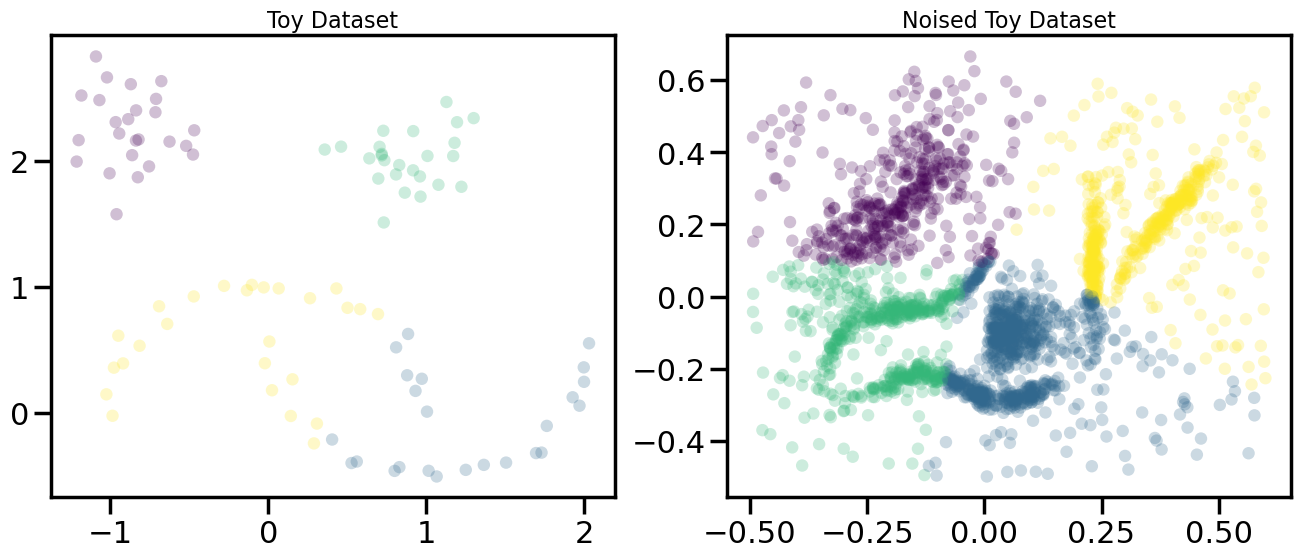

In [3]:
from sklearn.cluster import KMeans
kmeans_0 = KMeans(n_clusters=4, max_iter=200).fit(test_data_0)
kmeans_1 = KMeans(n_clusters=4, max_iter=200).fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=kmeans_0.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=kmeans_1.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show();

Agglomerative clustering is a suite of algorithms all based on the same idea. The fundamental idea is that you start with each point in it's own cluster and then, for each cluster, use some criterion to choose another cluster to merge with. Do this repeatedly until you have only one cluster and you get get a hierarchy, or binary tree, of clusters branching down to the last layer which has a leaf for each point in the dataset. The most basic version of this, single linkage, chooses the closest cluster to merge, and hence the tree can be ranked by distance as to when clusters merged/split.

**Code your own Aglomerative Single Linkage clustering algorithm**!:

- Fill in the class 
- During the process, keep track of the cluster merges by saving a (num_samples-1,4) np.array being a linkage matrix in scypy format (to use their function to plot dendrogram: `scipy.cluster.hierarchy.dendrogram`). check documentation.

In [5]:
import numpy as np
from scipy.spatial import distance
from scipy.cluster import hierarchy
from copy import deepcopy


class my_SingleLinkageAglomerativeClustering():
    
    def __init__(self, metric="euclidean", n_clusters=3):
        self.metric_ = metric
        self.n_clusters_ = n_clusters
        self.linkage_matrix_ = None
        self.labels_ = None
        self.hierarchy_ = None

    def find_min(self, D):
        """Return the smallest non-zero distance in D and its indices."""
        n = D.shape[0]
        min_val = np.inf
        r_min, c_min = 0, 1
        for i in range(n):
            for j in range(i + 1, n):
                if 0 < D[i, j] < min_val:
                    min_val = D[i, j]
                    r_min, c_min = i, j
        return min_val, r_min, c_min

    def compute_dist(self, cluster_a, cluster_b, X, metric):
        """Compute the single-link (minimum) distance between two clusters."""
        dist_block = distance.cdist(X[cluster_a], X[cluster_b], metric=metric)
        return np.min(dist_block)

    def update_dic(self, clusters, i_min, j_min, n, step):
        """Update dictionary after merging two clusters."""
        total_points = clusters[i_min][1] + clusters[j_min][1]
        remaining_keys = [k for k in clusters if k not in (i_min, j_min)]
        new_clusters = {}

        k_small, k_large = sorted((i_min, j_min))
        for k in remaining_keys:
            offset = 0
            if k > k_large:
                offset = -2
            elif k > k_small:
                offset = -1
            new_clusters[k + offset] = clusters[k]

        new_clusters[n - step - 2] = [n + step, total_points]
        return new_clusters

    def update_matrix(self, D, i, j, step, X, metric, n, clusters):
        """Update distance matrix after merging clusters i and j."""
        D = np.delete(D, [i, j], axis=0)
        D = np.delete(D, [i, j], axis=1)

        m = D.shape[0] + 1
        new_D = np.zeros((m, m))
        new_D[:-1, :-1] = D

        new_row = np.zeros(m)
        new_cluster_idx = np.where(self.hierarchy_[step + 1] == n + step)[0]
        for idx, key in enumerate(clusters.keys()):
            old_cluster_idx = np.where(self.hierarchy_[step + 1] == clusters[key][0])[0]
            new_row[idx] = self.compute_dist(new_cluster_idx, old_cluster_idx, X, metric)

        new_D[-1, :] = new_row
        new_D[:, -1] = new_row
        np.fill_diagonal(new_D, 0)
        return new_D

    def fit(self, X):
        """Perform single-linkage agglomerative clustering."""
        n = X.shape[0]
        self.hierarchy_ = [np.arange(n)]
        self.linkage_matrix_ = np.zeros((n - 1, 4))

        D = distance.cdist(X, X, metric=self.metric_)
        clusters = {i: [i, 1] for i in range(n)}

        for step in range(n - 1):
            print(f"Iteration {step + 1}/{n - 1}")

            d_min, i_min, j_min = self.find_min(D)
            c1, c2 = clusters[i_min][0], clusters[j_min][0]
            count = clusters[i_min][1] + clusters[j_min][1]

            self.linkage_matrix_[step] = [c1, c2, d_min, count]

            current_state = deepcopy(self.hierarchy_[step])
            mask = np.isin(current_state, [c1, c2])
            current_state[mask] = n + step
            self.hierarchy_.append(current_state)

            clusters = self.update_dic(clusters, i_min, j_min, n, step)
            D = self.update_matrix(D, min(i_min, j_min), max(i_min, j_min),
                                   step, X, self.metric_, n, clusters)

        self.labels_ = self.hierarchy_[-self.n_clusters_]
        return self

    def plot_dendrogram(self):
        """Plot dendrogram using scipy."""
        hierarchy.dendrogram(self.linkage_matrix_)


Apply the method to our toy datasets

In [7]:
model  = my_SingleLinkageAglomerativeClustering(n_clusters=4)
model.fit(test_data_0)

Iteration 1/99
Iteration 2/99
Iteration 3/99
Iteration 4/99
Iteration 5/99
Iteration 6/99
Iteration 7/99
Iteration 8/99
Iteration 9/99
Iteration 10/99
Iteration 11/99
Iteration 12/99
Iteration 13/99
Iteration 14/99
Iteration 15/99
Iteration 16/99
Iteration 17/99
Iteration 18/99
Iteration 19/99
Iteration 20/99
Iteration 21/99
Iteration 22/99
Iteration 23/99
Iteration 24/99
Iteration 25/99
Iteration 26/99
Iteration 27/99
Iteration 28/99
Iteration 29/99
Iteration 30/99
Iteration 31/99
Iteration 32/99
Iteration 33/99
Iteration 34/99
Iteration 35/99
Iteration 36/99
Iteration 37/99
Iteration 38/99
Iteration 39/99
Iteration 40/99
Iteration 41/99
Iteration 42/99
Iteration 43/99
Iteration 44/99
Iteration 45/99
Iteration 46/99
Iteration 47/99
Iteration 48/99
Iteration 49/99
Iteration 50/99
Iteration 51/99
Iteration 52/99
Iteration 53/99
Iteration 54/99
Iteration 55/99
Iteration 56/99
Iteration 57/99
Iteration 58/99
Iteration 59/99
Iteration 60/99
Iteration 61/99
Iteration 62/99
Iteration 63/99
I

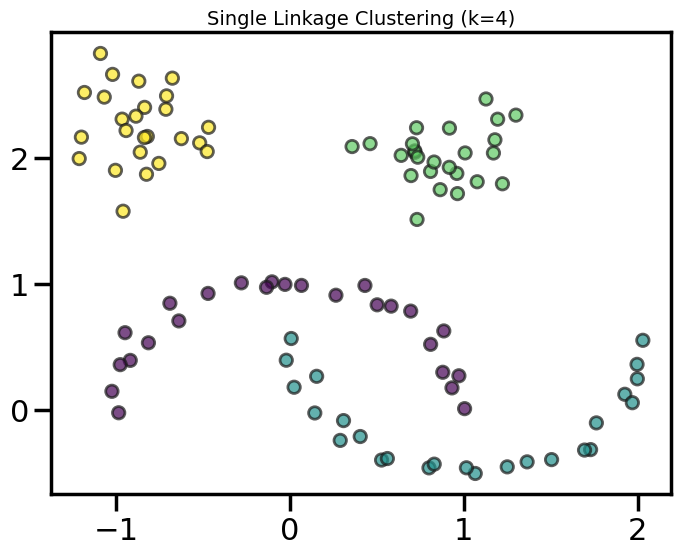

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(test_data_0[:, 0], test_data_0[:, 1], c=model.labels_, cmap='viridis', s=80, alpha=0.7, edgecolors='k')
ax.set_title(f'Single Linkage Clustering (k={model.n_clusters_})', fontsize=14)
plt.show()


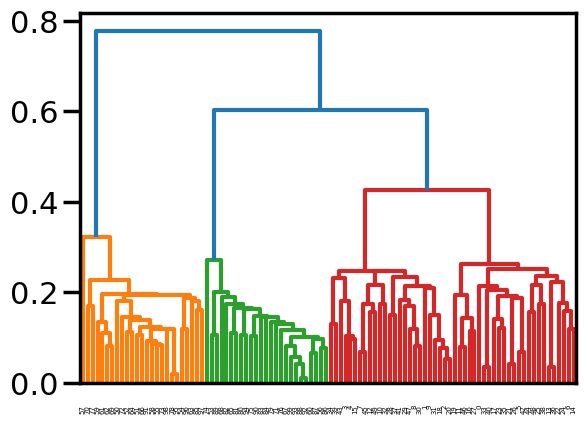

In [9]:
model.plot_dendrogram()

Try the different linkage methods implemented in `sklearn`  and comment

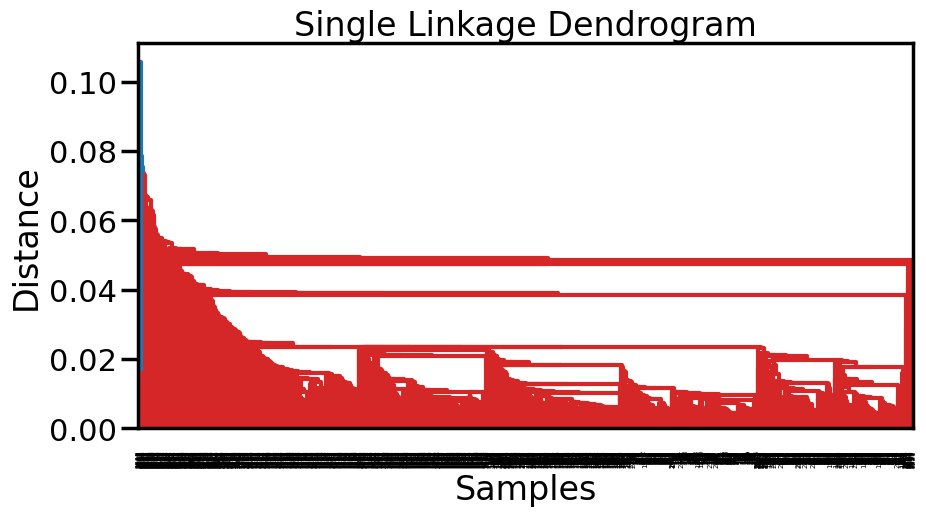

In [10]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

x_test = test_data_1
Z = linkage(x_test, method='single')

plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title("Single Linkage Dendrogram")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

## DBSCAN

DBSCAN is a density based algorithm -- it assumes clusters for dense regions. It is also the first actual clustering algorithm we've looked at: it doesn't require that every point be assigned to a cluster and hence doesn't partition the data, but instead extracts the 'dense' clusters and leaves sparse background classified as 'noise'. In practice DBSCAN is related to agglomerative clustering. As a first step DBSCAN transforms the space according to the density of the data: points in dense regions are left alone, while points in sparse regions are moved further away. Applying single linkage clustering to the transformed space results in a dendrogram, which we cut according to a distance parameter (called epsilon or `eps` in many implementations) to get clusters. Importantly any singleton clusters at that cut level are deemed to be 'noise' and left unclustered. 

Apply it to the test_data, how do you tune the parameters?

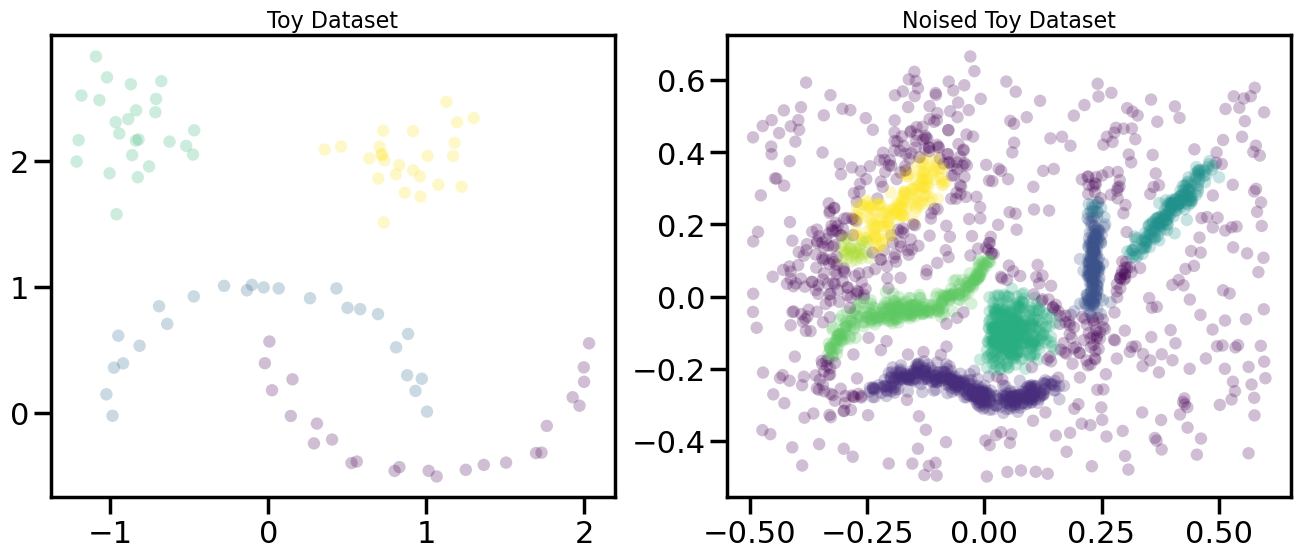

In [11]:
from sklearn.cluster import DBSCAN

clustering_DBSCAN_0 = DBSCAN(eps=0.4, min_samples=2).fit_predict(test_data_0)
clustering_DBSCAN_1 = DBSCAN(eps=0.03, min_samples=20).fit_predict(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=clustering_DBSCAN_0 , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=clustering_DBSCAN_1 , **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)

plt.show();

**Answer**: 
To tune the parameters, we start by setting them to rather loose values so that all points could easily be connected (min_samples small and eps large). This usually merges everything into one big cluster, which means the radius is too large.
Then, we progressively decrease the neighborhood size (eps) to make the algorithm more selective. As we reduce it, separate groups of points begin to appear.
For each chosen eps, we also test different values of min_samples to see how sensitive the model was to small variations. A small min_samples value tends to connect clusters through noisy points, while larger values make the algorithm stricter and can break clusters apart. The right balance is found when the main dense regions are clearly identified, and only the truly isolated points are considered noise.

## HDBSCAN

HDBSCAN is a recent algorithm developed by some of the same people who write the original DBSCAN paper. Their goal was to allow varying density clusters. The algorithm starts off much the same as DBSCAN: we transform the space according to density, exactly as DBSCAN does, and perform single linkage clustering on the transformed space. Instead of taking an epsilon value as a cut level for the dendrogram however, a different approach is taken: the dendrogram is condensed by viewing splits that result in a small number of points splitting off as points 'falling out of a cluster'. This results in a smaller tree with fewer clusters that 'lose points'. That tree can then be used to select the most stable or persistent clusters. This process allows the tree to be cut at varying height, picking our varying density clusters based on cluster stability.

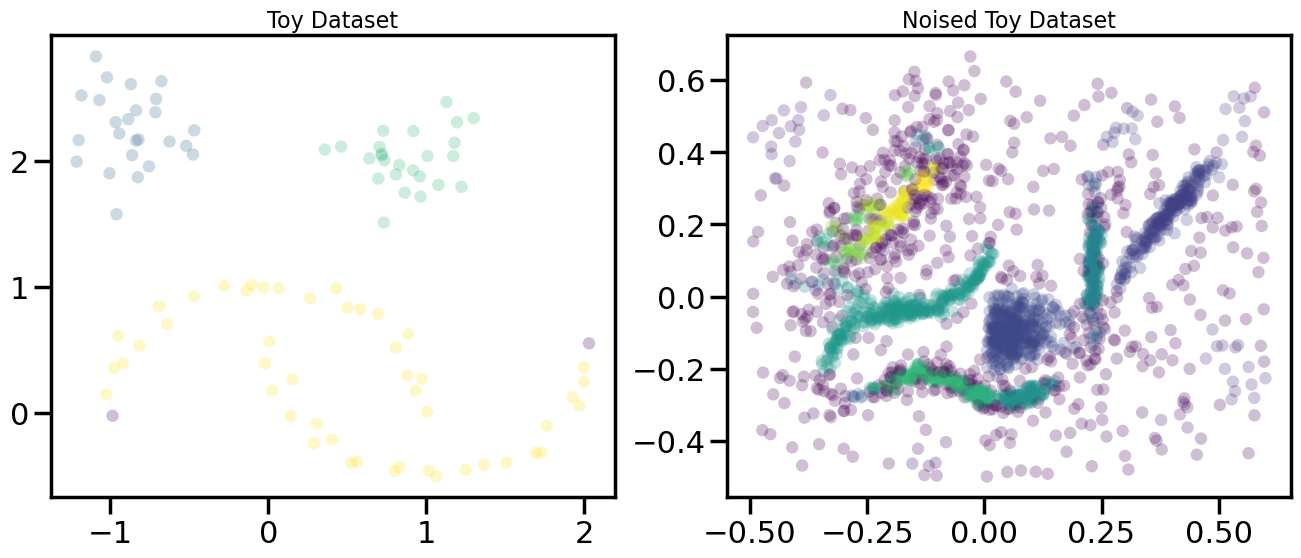

In [12]:
import hdbscan

clustering_HDBSCAN_0 = hdbscan.HDBSCAN().fit_predict(test_data_0)
clustering_HDBSCAN_1 = hdbscan.HDBSCAN().fit_predict(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=clustering_HDBSCAN_0 , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=clustering_HDBSCAN_1 , **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)

plt.show();

## Apply the algorithms to the following images and comment the results

### NASA Curiosity Picture

- Look at following NASA photo taken by a robot in mars:


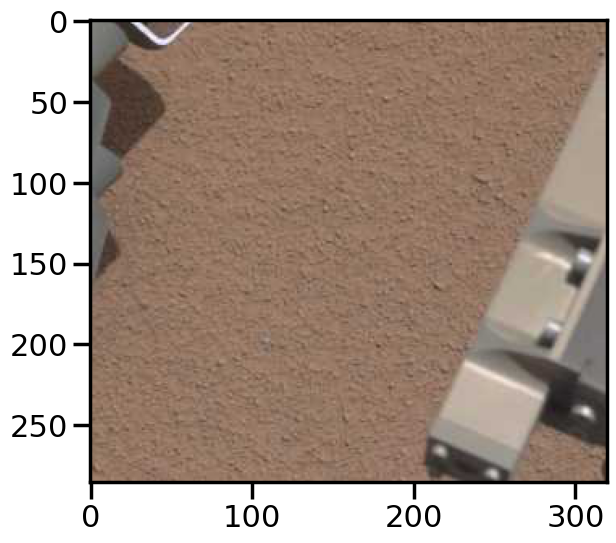

In [13]:
from PIL import Image

Im_1  = Image.open('im_nasa_reduced.jpg')

fig = plt.figure(figsize=(8, 6))
plt.imshow(Im_1)
plt.show()

- Transform the image to an intensity (I) and saturation (S) representation, it helps to distinguish bright and textures.

$$I=\frac{R+G+B}{3}$$
$$S=1-I\times min(R, G, B)$$

In [14]:
M = np.array(Im_1)
N = np.zeros((M.shape[0],M.shape[1]))
for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        N[i][j] = min(M[i][j][0],M[i][j][1],M[i][j][2])


I = (M[:,:,0] + M[:,:,1] + M[:,:,2])/3
S = (255*255-I*N)/(255*255)

- Apply the seen algorithms to segment the image in the Intensity-Saturation representation, comment the results and check if you find something on mars' surface. Be careful with hdbscan and memory errors for some parameters choice (use algorithm='boruvka_kdtree').

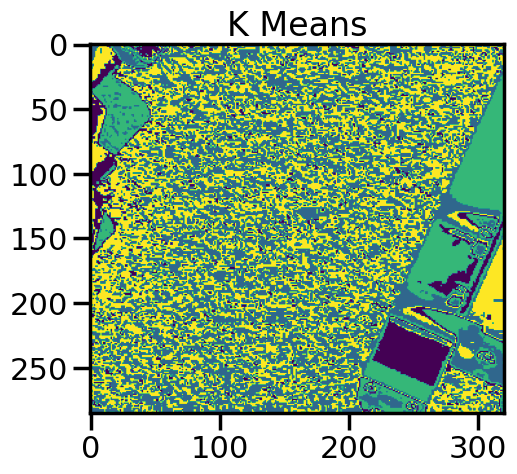

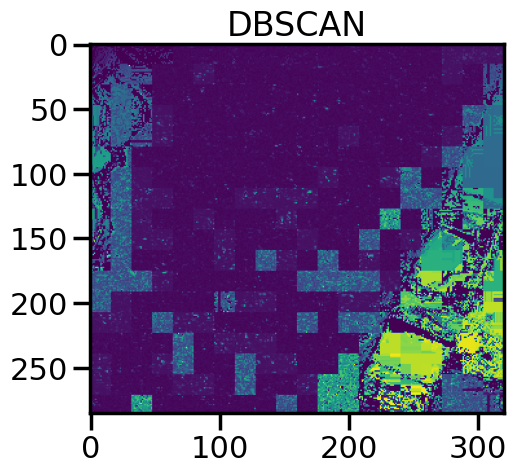

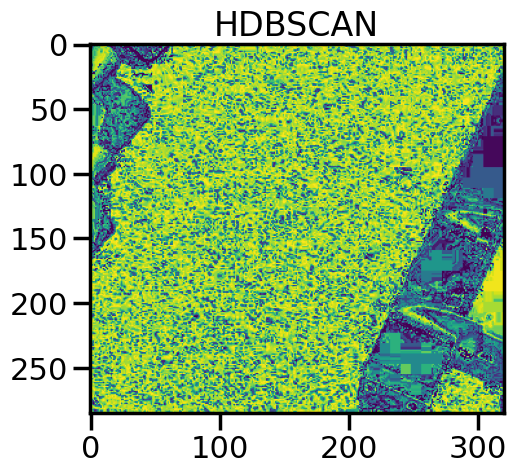

In [15]:
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.cluster import KMeans
from pylab import imshow, title

IS = np.zeros((M.shape[0]*M.shape[1],2))
for i in range(M.shape[0]):
    for j in range(N.shape[1]):

        IS[i*N.shape[1]+j] = [I[i][j],S[i][j]]

clustering_HDBSCAN = hdbscan.HDBSCAN().fit_predict(IS).reshape((286,320))
clustering_DBSCAN  = DBSCAN(eps=0.0001, min_samples=5).fit_predict(IS).reshape((286,320))
clustering_K_Means = KMeans(n_clusters=4, max_iter=200).fit_predict(IS).reshape((286,320))

im1 = imshow(clustering_K_Means)
title('K Means')
plt.show()
im2 = imshow(clustering_DBSCAN)
title('DBSCAN')
plt.show()
im3 = imshow(clustering_HDBSCAN)
title('HDBSCAN')
plt.show()

### Color compression

One interesting application of clustering is in color compression within images. 
For example, imagine you have an image with millions of colors.
In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

Get a simplified 10-colored version of the following image by applying k-means. Plot both images.

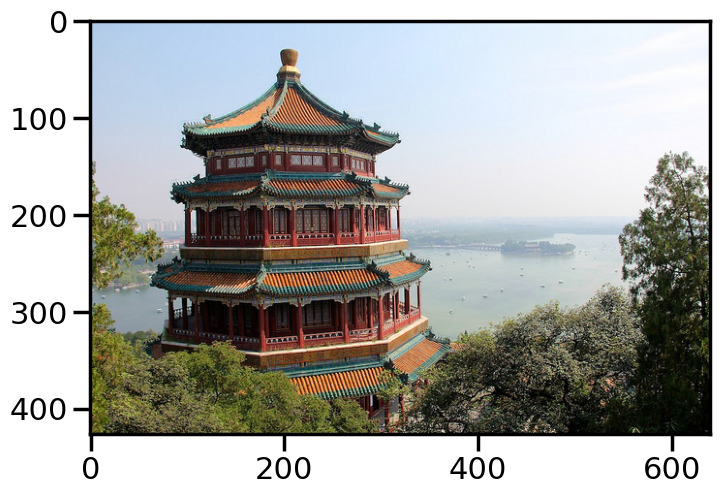

In [16]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")

fig = plt.figure(figsize=(8, 6))
plt.imshow(china);

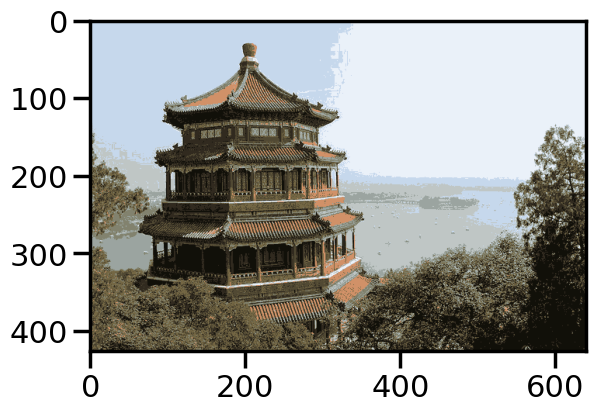

In [17]:
h,w = china.shape[:2]
array = china.reshape(-1,3)
cluster = KMeans(n_clusters=10)
labels = cluster.fit_predict(array)
china_compressed = cluster.cluster_centers_[labels].reshape(h,w,3)/255

plt.imshow(china_compressed)